In [1]:
!pip install gradio librosa scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.5 MB/s eta 0:00:00


In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from google.colab import files
import zipfile

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
audio_folder = "/content/drive/MyDrive/datasets/step2 sound blocks"

In [7]:
# Physical constants
P0 = 20e-6  # Reference pressure (Pa)
rho = 1.21  # Air density (kg/m^3)
c = 343     # Speed ​​of sound (m/s)
duration = 1.0  # Each file is 1 second long

# To contain the results
data = []

In [8]:
# Go through each .wav file in the folder and subfolders
for root, _, files in os.walk(audio_folder):
    for filename in tqdm(files):
        if filename.endswith(".wav"):
            filepath = os.path.join(root, filename)

            try:
                y, sr = librosa.load(filepath, sr=None)
                amplification_factor = 10.0
                y = y * amplification_factor
                duration = len(y) / sr

                rms = np.sqrt(np.mean(y**2))

                # Convert to SPL (estimated)
                spl = 20 * np.log10(rms / P0 + 1e-12)

                # Pressure calculation
                pressure = P0 * (10 ** (spl / 20))

                # Energy from sound
                power = (pressure ** 2) / (rho * c)
                energy_wh = power * duration / 3600

                data.append({
                    'filename': filename,
                    'rms': rms,
                    'spl_db': spl,
                    'pressure_pa': pressure,
                    'power_w': power,
                    'energy_wh': energy_wh
                })

            except Exception as e:
                print(f"File error {filename}: {e}")


0it [00:00, ?it/s]
100%|██████████| 7340/7340 [03:06<00:00, 39.34it/s] 


In [9]:
# Convert the results to a DataFrame and store them.
results_df = pd.DataFrame(data)
results_df.to_csv("audio_energy_dataset.csv", index=False)
print("All files successfully extracted and analyzed")

All files successfully extracted and analyzed


In [10]:
#Define properties and inputs
X = results_df[['rms', 'spl_db']]
y = results_df['energy_wh']
print(results_df.columns)
results_df.head()


Index(['filename', 'rms', 'spl_db', 'pressure_pa', 'power_w', 'energy_wh'], dtype='object')


,filename,rms,spl_db,pressure_pa,power_w,energy_wh
0,appn001200000222.wav,0.659913,90.369125,0.659913,0.001049,2.914680e-07
1,appn001200000204.wav,0.703868,90.929230,0.703869,0.001194,3.315898e-07
2,appn001200000223.wav,0.683404,90.672951,0.683404,0.001125,3.125886e-07
3,appn001200000219.wav,0.676954,90.590584,0.676954,0.001104,3.067158e-07
4,appn001200000207.wav,0.730257,91.248917,0.730257,0.001285,3.569187e-07


In [11]:
#Data partitioning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "trained_energy_model.pkl")
print("The model has been trained and stored")

#Prediction
y_pred = model.predict(X_test)

The model has been trained and stored


In [12]:
for i in range(10):
    actual = y_test.iloc[i]
    predicted = y_pred[i]
    print(f"{i+1}: Actual = {actual:.10f}, Predicted = {predicted:.10f}, Diff = {abs(actual - predicted):.10f}")


1: Actual = 0.0000003704, Predicted = 0.0000003478, Diff = 0.0000000226
2: Actual = 0.0000001622, Predicted = 0.0000001401, Diff = 0.0000000220
3: Actual = 0.0000001668, Predicted = 0.0000001432, Diff = 0.0000000237
4: Actual = 0.0000004587, Predicted = 0.0000004490, Diff = 0.0000000097
5: Actual = 0.0000003926, Predicted = 0.0000003732, Diff = 0.0000000194
6: Actual = 0.0000004107, Predicted = 0.0000003939, Diff = 0.0000000168
7: Actual = 0.0000003796, Predicted = 0.0000003583, Diff = 0.0000000213
8: Actual = 0.0000002589, Predicted = 0.0000002253, Diff = 0.0000000335
9: Actual = 0.0000002837, Predicted = 0.0000002515, Diff = 0.0000000322
10: Actual = 0.0000009657, Predicted = 0.0000010057, Diff = 0.0000000400


In [13]:
#Performance Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\n Model results:")
print(f"Mean Squared Error: {mse:.20f}")
print(f"R^2 Score: {r2:.4f}")


 Model results:
Mean Squared Error: 0.00000000000000345415
R^2 Score: 0.9826


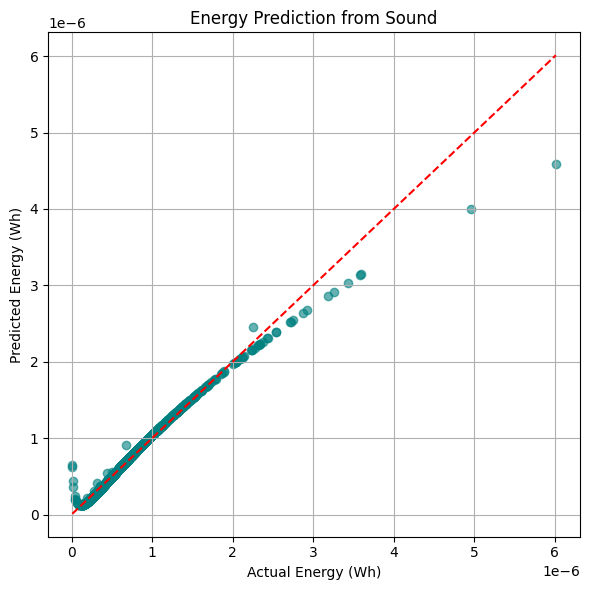

,filename,rms,spl_db,pressure_pa,power_w,energy_wh
0,appn001200000222.wav,0.659913,90.369125,0.659913,0.001049,2.914680e-07
1,appn001200000204.wav,0.703868,90.929230,0.703869,0.001194,3.315898e-07
2,appn001200000223.wav,0.683404,90.672951,0.683404,0.001125,3.125886e-07
3,appn001200000219.wav,0.676954,90.590584,0.676954,0.001104,3.067158e-07
4,appn001200000207.wav,0.730257,91.248917,0.730257,0.001285,3.569187e-07


In [14]:
#Comparison Chart
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Energy (Wh)")
plt.ylabel("Predicted Energy (Wh)")
plt.title("Energy Prediction from Sound")
plt.grid(True)
plt.tight_layout()
plt.show()

results_df.head()

In [15]:
import gradio as gr
import librosa
import numpy as np
import pandas as pd
import io
import base64
import random


G = 9.81
STEP_COMPRESSION = 0.01
P0 = 20e-6

total_energy_wh = 0.0
step_count = 0


def energy_from_step(weight):
    return 0.0000469

def energy_from_audio(audio):
    y, sr = librosa.load(audio, sr=None)
    rms = np.sqrt(np.mean(y**2))
    spl = 20 * np.log10(rms / P0 + 1e-12)
    features = np.array([[rms, spl]])
    energy_pred = model.predict(features)[0]
    return energy_pred


def simulate_step(weight):
    global total_energy_wh, step_count
    step_count += 1
    step_energy = energy_from_step(weight)
    total_energy_wh += step_energy
    return update_output("خطوة واحدة", step_energy)

def simulate_audio(audio):
    global total_energy_wh
    if audio is None:
        return "يرجى رفع ملف صوتي للمشجعين." , "", "", 0.0
    audio_energy = energy_from_audio(audio)
    total_energy_wh += audio_energy
    return update_output("تشجيع جماهيري", audio_energy)

def reset():
    global total_energy_wh, step_count
    total_energy_wh = 0.0
    step_count = 0
    return "🔄 تم تصفير المحاكاة.", "👟 عدد الخطوات: 0", "🔋 الطاقة المتراكمة: 0.0000000000 Wh", 0.0

def update_output(source, energy):
    return (
        f"✅ تم احتساب طاقة من {source}: {energy:.10f} Wh",
        f"👟 عدد الخطوات: {step_count}",
        f"🔋 الطاقة المتراكمة: {total_energy_wh:.10f} Wh",
        total_energy_wh
    )


with gr.Blocks() as demo:
    gr.Markdown("""
    # 🏟️ محاكاة توليد الطاقة من الجمهور
    تجربة تفاعلية لاحتساب الطاقة الكهربائية الناتجة من التشجيع والخطوات.
    """)

    with gr.Row():
        weight = gr.Number(label="⚖️ وزن الشخص (كجم)", value=70)
        step_button = gr.Button("👣 اضغط لمحاكاة خطوة")
        audio_input = gr.Audio(label="🔊 صوت الجمهور", type="filepath")
        audio_button = gr.Button("🎧 احسب طاقة الصوت")
        reset_button = gr.Button("🔁 تصفير")

    msg = gr.Textbox(label="📢 النتيجة")
    step_display = gr.Textbox(label="👣 عدد الخطوات")
    total_display = gr.Textbox(label="⚡ الطاقة الكلية (Wh)")
    energy_bar = gr.Slider(minimum=0, maximum=1, value=0, step=0.00001, label="🔋 شريط الطاقة", interactive=False)

    step_button.click(simulate_step, inputs=weight, outputs=[msg, step_display, total_display, energy_bar])
    audio_button.click(simulate_audio, inputs=audio_input, outputs=[msg, step_display, total_display, energy_bar])
    reset_button.click(reset, outputs=[msg, step_display, total_display, energy_bar])

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8812e04b30e9c48795.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
